Extracted files: ['val', 'train', 'Fire-Detection']
Found 520 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7006 - loss: 0.4961 - val_accuracy: 0.8321 - val_loss: 0.3911
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8288 - loss: 0.3861 - val_accuracy: 0.8321 - val_loss: 0.3033
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8581 - loss: 0.3027 - val_accuracy: 0.8855 - val_loss: 0.2686
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8873 - loss: 0.2793 - val_accuracy: 0.8702 - val_loss: 0.3270
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8589 - loss: 0.3586 - val_accuracy: 0.9084 - val_loss: 0.2573
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9247 - loss: 0.1965 - val_accuracy: 0.8626 - val_loss: 0.3186
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9192 - loss: 0.1851 - val_accuracy: 0.9084 - val_loss: 0.2528
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9371 - loss: 0.1745 - val_accuracy: 0.9008 - val_loss:

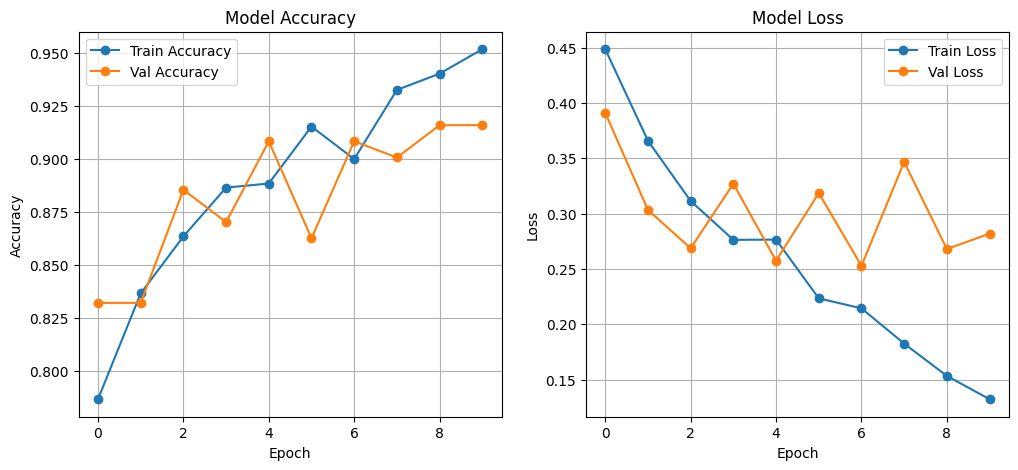

Class labels: ['0', '1']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


/tmp/ipython-input-2461828507.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_labels[int(predicted_classes[i])]


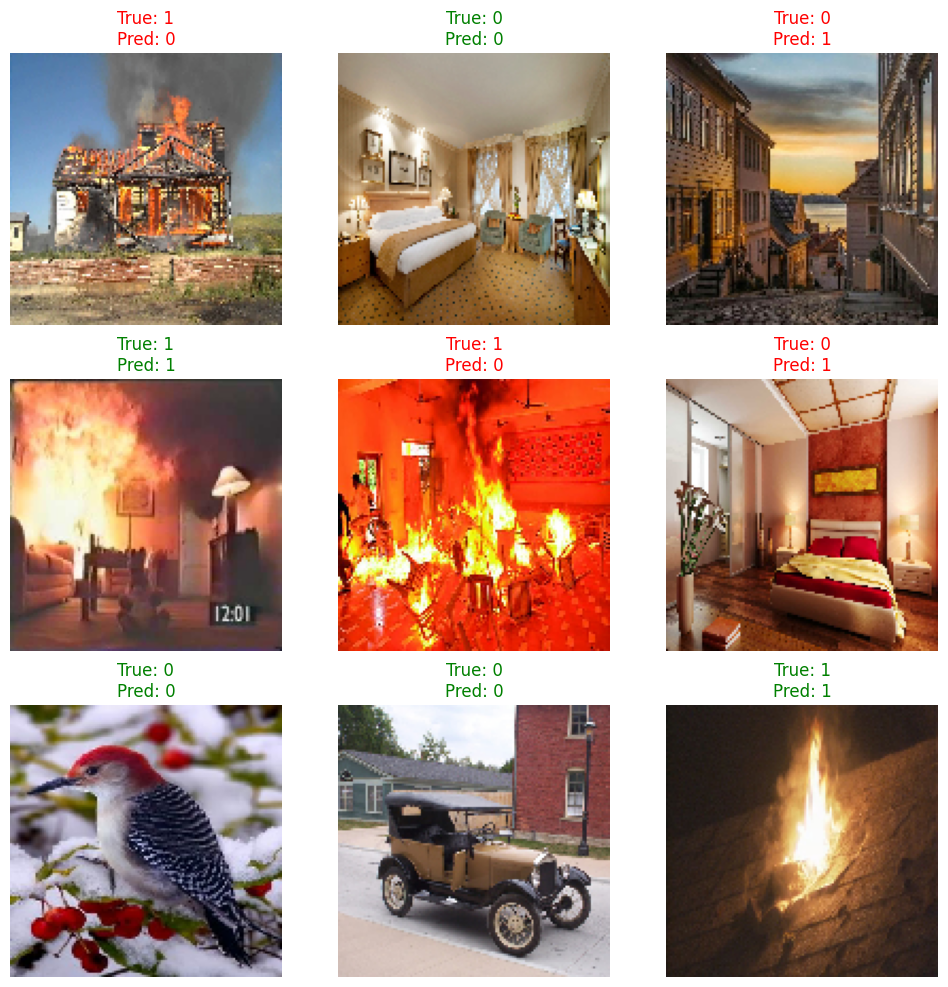

In [22]:
import os
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# 1. Paths
# ==============================
dataset_path = "/content/dataset"
zip_path = "/content/archive (2).zip"  # change if different

# ==============================
# 2. Extract dataset
# ==============================
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Extracted files:", os.listdir(dataset_path))

# The dataset should now be at /content/dataset/Fire-Detection
main_data_dir = os.path.join(dataset_path, "Fire-Detection")

# ==============================
# 3. Train / validation split
# ==============================
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)

for class_name in os.listdir(main_data_dir):
    class_path = os.path.join(main_data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, class_name))
        os.makedirs(os.path.join(val_dir, class_name))

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img),
                        os.path.join(train_dir, class_name, img))

        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img),
                        os.path.join(val_dir, class_name, img))

# ==============================
# 4. Data generators
# ==============================
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# ==============================
# 5. CNN Model (clean version)
# ==============================
model = models.Sequential([
    Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ==============================
# 6. Training
# ==============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

# ==============================
# 7. Save model
# ==============================
model_save_path = "forest_fire_cnn.keras"
model.save(model_save_path)
print(f"✅ Model saved as {model_save_path}")

# ==============================
# 8. Accuracy & Loss Visualization
# ==============================
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

# ==============================
# 9. Sample Predictions
# ==============================
class_labels = list(train_gen.class_indices.keys())
print("Class labels:", class_labels)

# Take some images from validation set and predict
sample_imgs, sample_labels = next(val_gen)

predictions = model.predict(sample_imgs)
predicted_classes = (predictions > 0.5).astype("int32")

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_imgs[i])
    true_label = class_labels[int(sample_labels[i])]
    pred_label = class_labels[int(predicted_classes[i])]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.show()
